In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# TS
from prophet import Prophet

# User Imports
import sys

sys.path.append("..")
from src import util

# modeling
import optuna
from sklearn.metrics import mean_squared_error as mse


%load_ext lab_black
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (14, 7)

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load = util.read_load("./data/load_hist_data.csv")
weather = util.read_weather("./data/weather_data.csv")
weather_features = util.featurize_weather(
    weather, lags=[24]
)  # 24 hours = 1 day lagged weather

In [4]:
display(load.head())
weather_features.head(30)

y
ds                      
2005-01-01 00:00:00  857
2005-01-01 01:00:00  825
2005-01-01 02:00:00  800
2005-01-01 03:00:00  794
2005-01-01 04:00:00  802

ds  min_station_temp  max_station_temp  mean_station_temp  \
0  2005-01-01 00:00:00              39.0              53.0          46.107143   
1  2005-01-01 01:00:00              38.0              53.0          45.964286   
2  2005-01-01 02:00:00              37.0              52.0          44.964286   
3  2005-01-01 03:00:00              37.0              52.0          45.178571   
4  2005-01-01 04:00:00              37.0              51.0          44.714286   
5  2005-01-01 05:00:00              36.0              50.0          43.750000   
6  2005-01-01 06:00:00              37.0              50.0          43.892857   
7  2005-01-01 07:00:00              36.0              51.0          44.214286   
8  2005-01-01 08:00:00              35.0              54.0          47.928571   
9  2005-01-01 09:00:00              43.0              59.0          53.607143   
10 2005-01-01 10:00:00              51.0              66.0          59.000000   
11 2005-01-01 11:00:00              56.0              70.0          63.428571   
12 2005-01-01 12:00:00              57.0              71.0          66.214286   
13 2005-01-01 13:00:00              56.0              73.0          67.535714   
14 2005-01-01 14:00:00              56.0              73.0          68.178571   
15 2005-01-01 15:00:00              56.0              72.0          67.428571   
16 2005-01-01 16:00:00              54.0              71.0          64.250000   
17 2005-01-01 17:00:00              51.0              67.0          59.178571   
18 2005-01-01 18:00:00              50.0              62.0          55.928571   
19 2005-01-01 19:00:00              47.0              59.0          53.714286   
20 2005-01-01 20:00:00              46.0              57.0          51.857143   
21 2005-01-01 21:00:00              45.0              57.0          50.642857   
22 2005-01-01 22:00:00              44.0              55.0          49.035714   
23 2005-01-01 23:00:00              43.0              55.0          48.857143   
24 2005-01-02 00:00:00              42.0              55.0          48.000000   
25 2005-01-02 01:00:00              41.0              52.0          46.892857   
26 2005-01-02 02:00:00              39.0              57.0          46.500000   
27 2005-01-02 03:00:00              35.0              51.0          45.214286   
28 2005-01-02 04:00:00              36.0              52.0          44.785714   
29 2005-01-02 05:00:00              37.0              55.0          44.357143   

    lag_24__min_station_temp  lag_24__max_station_temp  \
0                       39.0                      53.0   
1                       38.0                      53.0   
2                       37.0                      52.0   
3                       37.0                      52.0   
4                       37.0                      51.0   
5                       36.0                      50.0   
6                       37.0                      50.0   
7                       36.0                      51.0   
8                       35.0                      54.0   
9                       43.0                      59.0   
10                      51.0                      66.0   
11                      56.0                      70.0   
12                      57.0                      71.0   
13                      56.0                      73.0   
14                      56.0                      73.0   
15                      56.0                      72.0   
16                      54.0                      71.0   
17                      51.0                      67.0   
18                      50.0                      62.0   
19                      47.0                      59.0   
20                      46.0                      57.0   
21                      45.0                      57.0   
22                      44.0                      55.0   
23                      43.0                      55.0   
24                      39.0                      53.0   


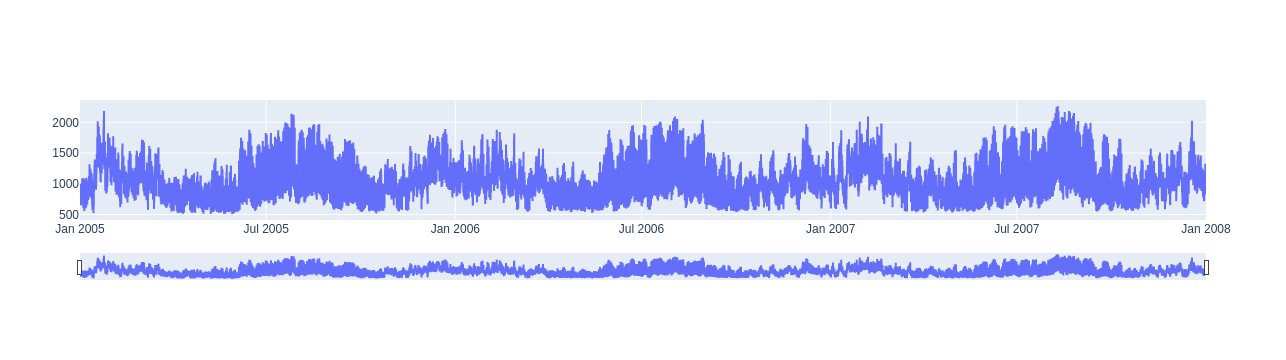

In [241]:
# Energy Load
util.slider_plot(data=load.reset_index(), x="ds", y="y")

Text(0.5, 1.0, 'Weather Station Data')

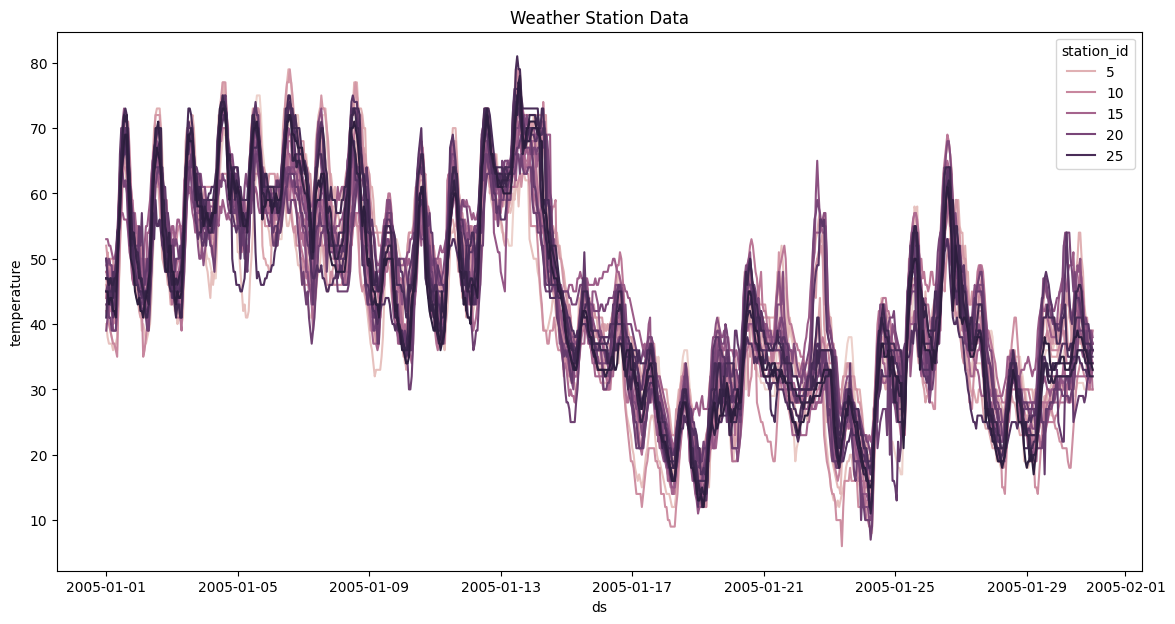

In [5]:
# Weather at each station
g = sns.lineplot(
    data=weather[weather.ds <= "2005-01-31"], x="ds", y="temperature", hue="station_id"
)
g.set_title("Weather Station Data")

Text(0.5, 1.0, 'Weather Features')

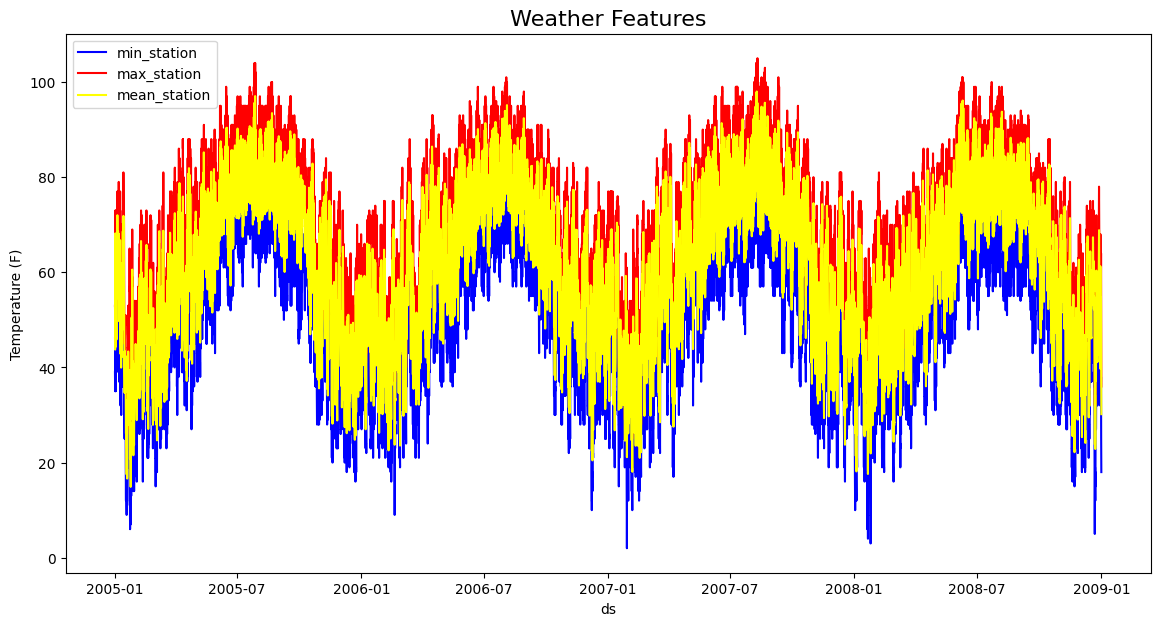

In [6]:
# Modeling Features (also have lagged versions)
g = sns.lineplot(
    data=weather_features,
    x="ds",
    y="min_station_temp",
    color="blue",
    label="min_station",
)
sns.lineplot(
    data=weather_features,
    x="ds",
    y="max_station_temp",
    color="red",
    label="max_station",
)
sns.lineplot(
    data=weather_features,
    x="ds",
    y="mean_station_temp",
    color="yellow",
    label="mean_station",
)
g.set_ylabel("Temperature (F)")
g.set_title("Weather Features", fontsize=16)

In [7]:
print(
    f"weather: {weather.ds.min().strftime('%Y-%m-%d')} - {weather.ds.max().strftime('%Y-%m-%d')}"
)
print(
    f"load: {load.index.min().strftime('%Y-%m-%d')} - {load.index.max().strftime('%Y-%m-%d')}"
)

weather: 2005-01-01 - 2008-12-31
load: 2005-01-01 - 2007-12-31


I will assume that we can use **actual** weather data from 2008 to predict load data from 2008.  
Normally, we would have to use a weather **forecast** for 2008 as to predict load from 2008.

Alternatives would be to use average yearly temperatures as exogenous data.

----------------

In [11]:
# def create_mod_data(load, weather):
#     mod_data = load.reset_index().copy()
#     mod_data["dow"] = mod_data.ds.dt.dayofweek
#     mod_data["school_break"] = (
#         (mod_data.ds.dt.month.isin([6, 5, 8]))  # Summer Time
#         | (
#             (mod_data.ds.dt.month == 12) & (mod_data.ds.dt.day >= 18)
#         )  # Winter Holiday Dec
#         | (
#             (mod_data.ds.dt.month == 1) & (mod_data.ds.dt.day <= 7)
#         )  # Winter Holiday Jan
#     )
#     mod_data = pd.get_dummies(mod_data, prefix="dow", prefix_sep="_", columns=["dow"])
#     mod_data = mod_data.merge(weather, on="ds", how="left")
#     return mod_data


mod_data = util.create_mod_data(load, weather_features)

In [12]:
mod_data.head()

ds    y  school_break  dow_0  dow_1  dow_2  dow_3  dow_4  \
0 2005-01-01 00:00:00  857          True  False  False  False  False  False   
1 2005-01-01 01:00:00  825          True  False  False  False  False  False   
2 2005-01-01 02:00:00  800          True  False  False  False  False  False   
3 2005-01-01 03:00:00  794          True  False  False  False  False  False   
4 2005-01-01 04:00:00  802          True  False  False  False  False  False   

   dow_5  dow_6  min_station_temp  max_station_temp  mean_station_temp  \
0   True  False              39.0              53.0          46.107143   
1   True  False              38.0              53.0          45.964286   
2   True  False              37.0              52.0          44.964286   
3   True  False              37.0              52.0          45.178571   
4   True  False              37.0              51.0          44.714286   

   lag_24__min_station_temp  lag_24__max_station_temp  \
0                      39.0                      53.0   
1                      38.0                      53.0   
2                      37.0                      52.0   
3                      37.0                      52.0   
4                      37.0                      51.0   

   lag_24__mean_station_temp  
0                  46.107143  
1                  45.964286  
2                  44.964286  
3                  45.178571  
4                  44.714286

DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/y0es3268.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/iu8i_a7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72845', 'data', 'file=/tmp/tmpov8ocpz9/y0es3268.json', 'init=/tmp/tmpov8ocpz9/iu8i_a7s.json', 'output', 'file=/tmp/tmpov8ocpz9/prophet_modelo65ago_1/prophet_model-20231219181829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds  dow_0  dow_1  dow_2  dow_3  dow_4  dow_5  dow_6  \
35056 2008-12-31 19:00:00  False  False   True  False  False  False  False   
35057 2008-12-31 20:00:00  False  False   True  False  False  False  False   
35058 2008-12-31 21:00:00  False  False   True  False  False  False  False   
35059 2008-12-31 22:00:00  False  False   True  False  False  False  False   
35060 2008-12-31 23:00:00  False  False   True  False  False  False  False   

       min_station_temp  max_station_temp  mean_station_temp  \
35056              21.0              43.0          36.642857   
35057              19.0              41.0          34.750000   
35058              19.0              39.0          33.464286   
35059              19.0              37.0          31.785714   
35060              18.0              36.0          30.178571   

       lag_24__min_station_temp  lag_24__max_station_temp  \
35056                      39.0                      57.0   
35057                      37.0                      59.0   
35058                      43.0                      59.0   
35059                      42.0                      57.0   
35060                      34.0                      58.0   

       lag_24__mean_station_temp  
35056                  49.535714  
35057                  49.892857  
35058                  49.785714  
35059                  49.607143  
35060                  49.428571

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

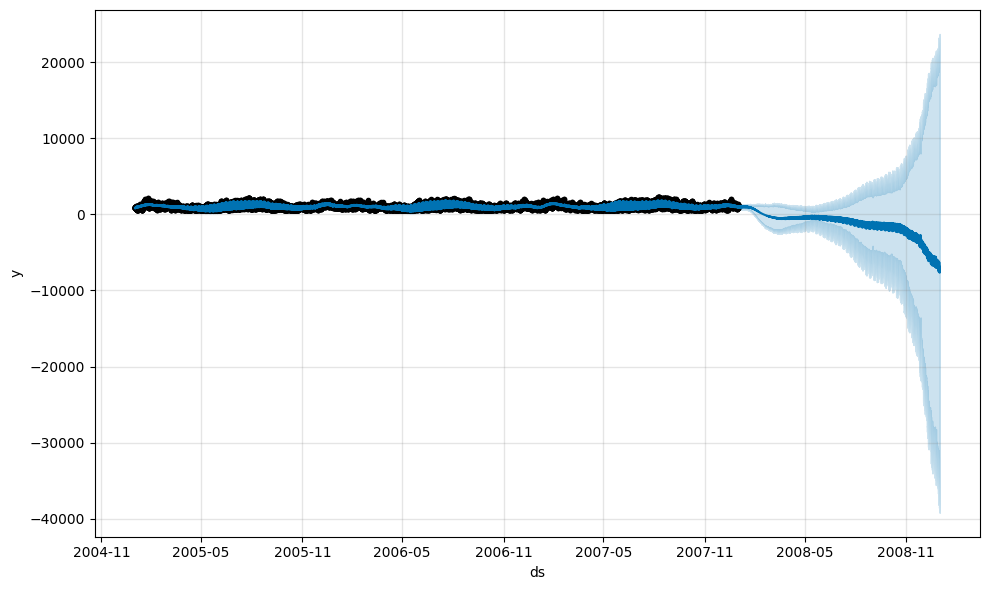

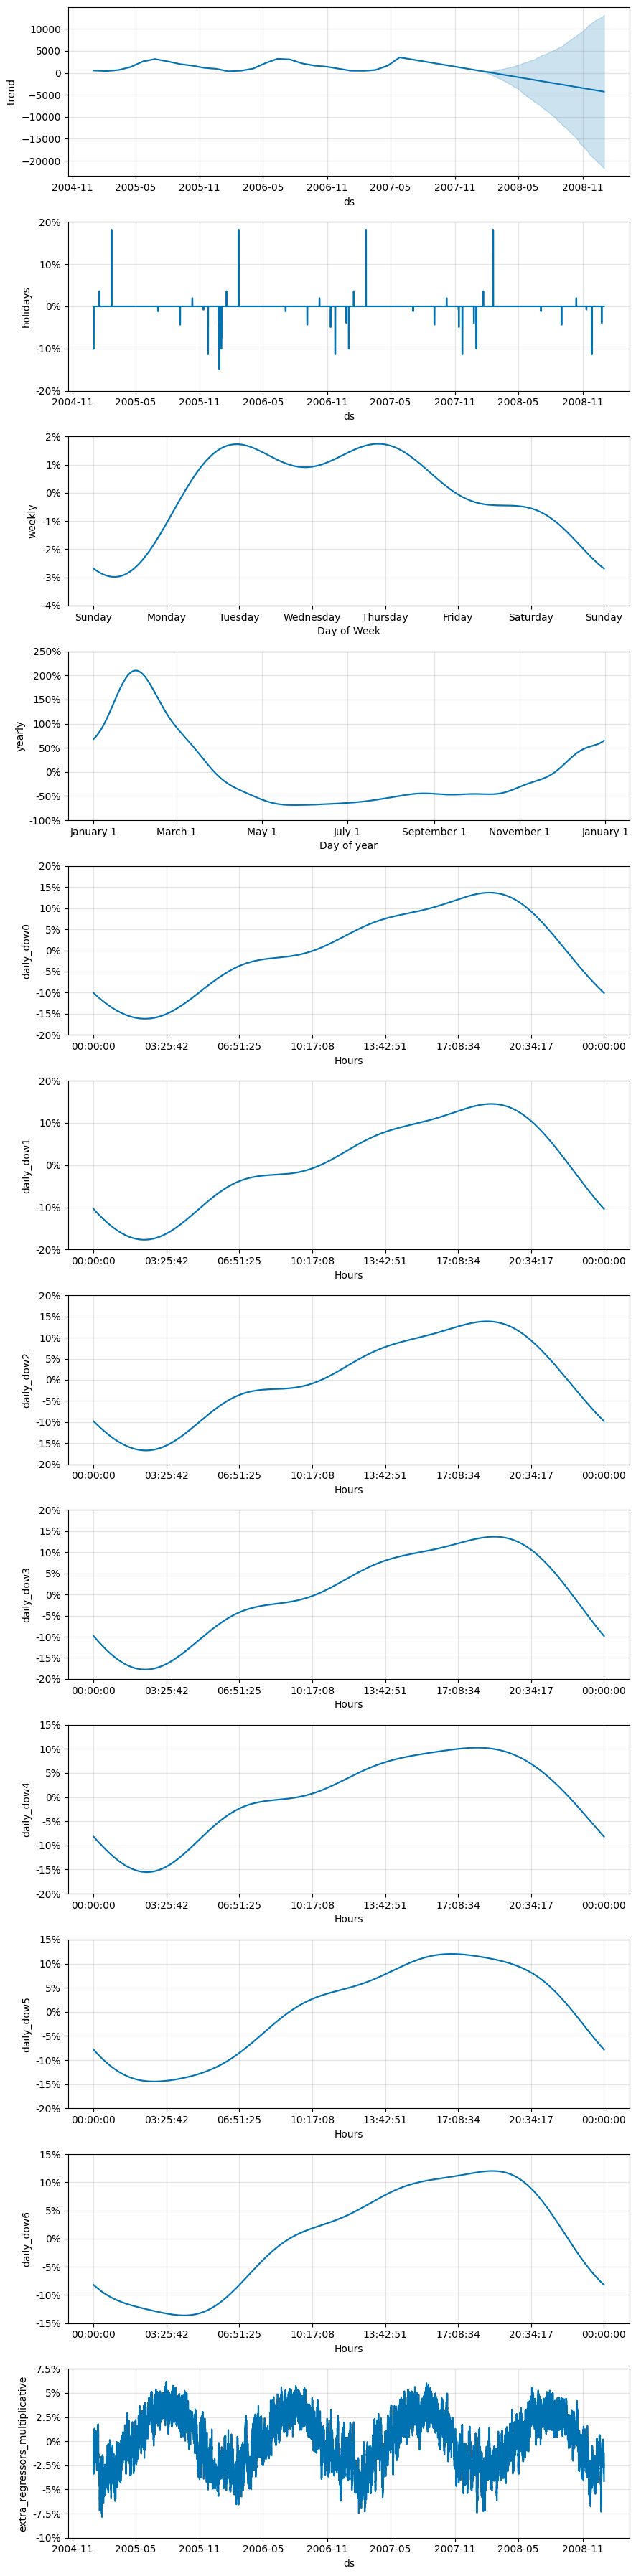

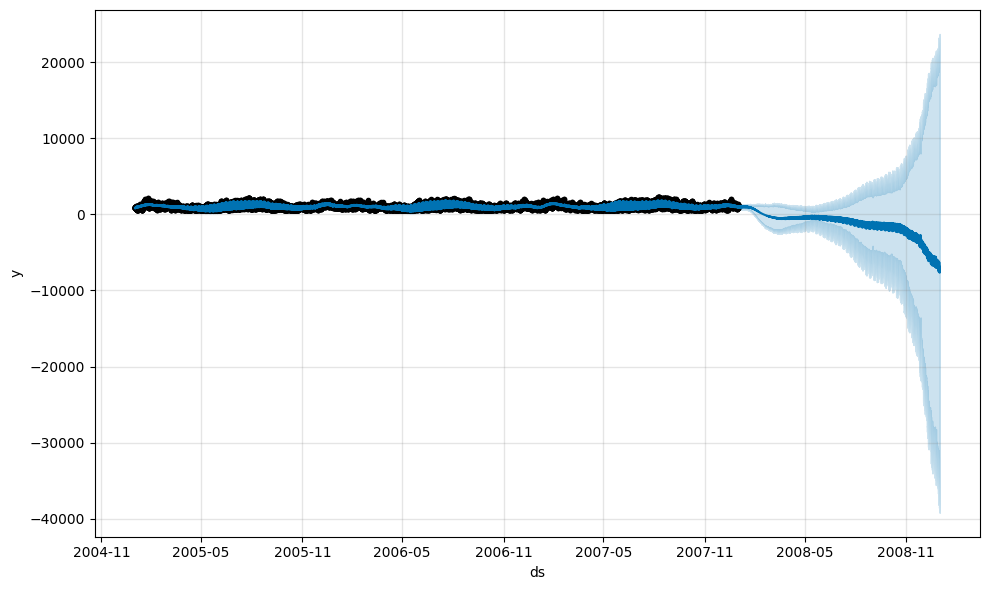

In [269]:
m = Prophet(
    daily_seasonality=False,
    # mcmc_samples=300,
    seasonality_mode="multiplicative",  # "additive",  # "multiplicative",
    changepoint_prior_scale=10,
)
for i in range(7):
    m.add_seasonality(
        name=f"daily_dow{i}", period=1, fourier_order=4, condition_name=f"dow_{i}"
    )

m.add_country_holidays(country_name="US")
m.add_regressor("max_station_temp")
m.add_regressor("min_station_temp")
m.add_regressor("mean_station_temp")
m.add_regressor("lag_24__min_station_temp")
m.add_regressor("lag_24__max_station_temp")
m.add_regressor("lag_24__mean_station_temp")

m.fit(mod_data)

future_df = m.make_future_dataframe(periods=(366) * 24, freq="H")
future_df = future_df[future_df.ds < "2009-01-01"]

future_df["dow"] = future_df.ds.dt.dayofweek
future_df = pd.get_dummies(future_df, prefix="dow", prefix_sep="_", columns=["dow"])
future_df = future_df.merge(weather_features, on="ds", how="left")
future_df["min_station_temp"].interpolate(inplace=True, method="linear")
future_df["max_station_temp"].interpolate(inplace=True, method="linear")
future_df["mean_station_temp"].interpolate(inplace=True, method="linear")


display(future_df.tail())

preds = m.predict(future_df)
fig = m.plot_components(preds)
m.plot(preds)

In [263]:
from prophet.plot import plot_plotly

In [271]:
# plot_plotly(m, preds[preds.ds < "2006"])

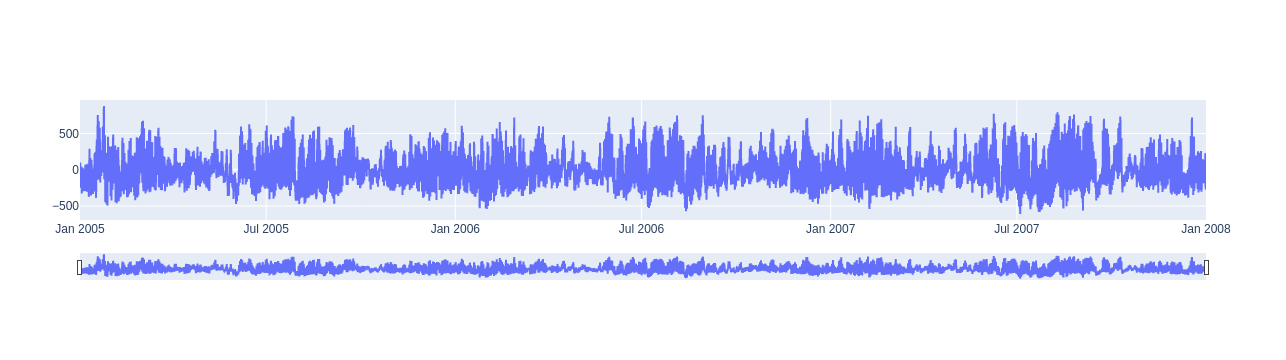

In [262]:
foo = preds[["ds", "yhat"]].merge(mod_data[["ds", "y"]], on=["ds"], how="inner")
foo["resid"] = foo["y"] - foo["yhat"]
slider_plot(data=foo, x="ds", y="resid")

In [273]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {
    "yearly_seasonality": [True],
    "weekly_seasonality": [True],
    "daily_seasonality": [False],
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    for i in range(7):
        m.add_seasonality(
            name=f"daily_dow{i}", period=1, fourier_order=4, condition_name=f"dow_{i}"
        )

    m.add_country_holidays(country_name="US")
    m.add_regressor("max_station_temp")
    m.add_regressor("min_station_temp")
    m.add_regressor("mean_station_temp")
    m.add_regressor("lag_24__min_station_temp")
    m.add_regressor("lag_24__max_station_temp")
    m.add_regressor("lag_24__mean_station_temp")

    m.fit(mod_data)

    df_cv = cross_validation(
        m,
        initial="730 days",
        period="180 days",
        horizon="60 days",
        parallel="processes",
    )
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p["rmse"].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["rmse"] = rmses
print(tuning_results)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/8iolw946.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/1xngzzt8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46056', 'data', 'file=/tmp/tmpov8ocpz9/8iolw946.json', 'init=/tmp/tmpov8ocpz9/1xngzzt8.json', 'output', 'file=/tmp/tmpov8ocpz9/prophet_modelcca1daot/prophet_model-20231219183140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2007-05-05 23:00:00 and 2007-11-01 23:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fec

<Axes: xlabel='seasonality_prior_scale', ylabel='changepoint_prior_scale'>

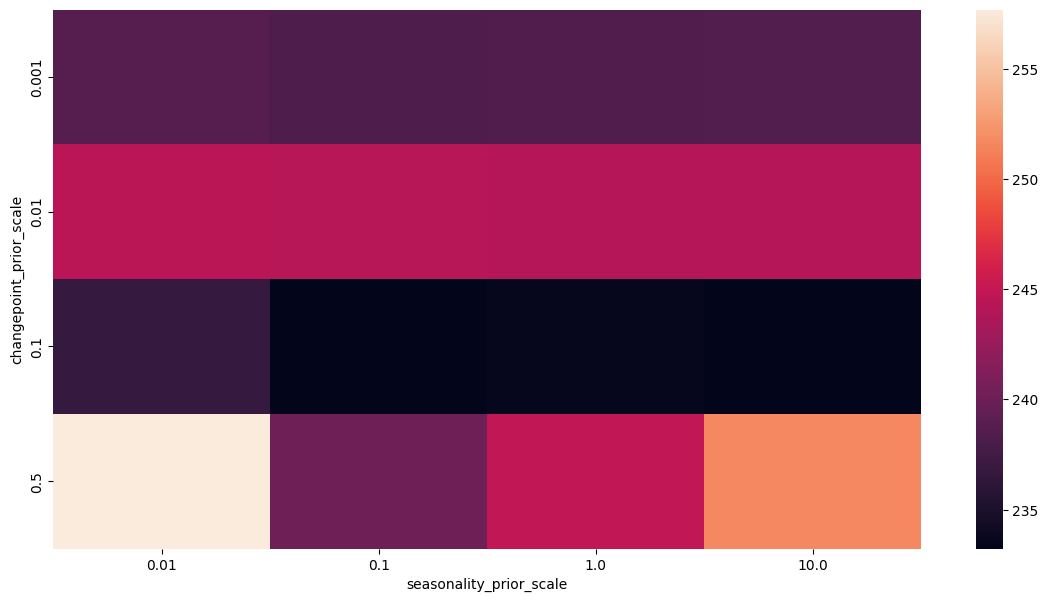

In [286]:
sns.heatmap(
    tuning_results[
        ["changepoint_prior_scale", "seasonality_prior_scale", "rmse"]
    ].pivot_table(
        index="changepoint_prior_scale",
        columns="seasonality_prior_scale",
        values="rmse",
    )
)

In [274]:
tuning_results

yearly_seasonality  weekly_seasonality  daily_seasonality  \
0                 True                True              False   
1                 True                True              False   
2                 True                True              False   
3                 True                True              False   
4                 True                True              False   
5                 True                True              False   
6                 True                True              False   
7                 True                True              False   
8                 True                True              False   
9                 True                True              False   
10                True                True              False   
11                True                True              False   
12                True                True              False   
13                True                True              False   
14                True                True              False   
15                True                True              False   

    changepoint_prior_scale  seasonality_prior_scale        rmse  
0                     0.001                     0.01  238.686087  
1                     0.001                     0.10  238.257902  
2                     0.001                     1.00  238.343953  
3                     0.001                    10.00  238.402437  
4                     0.010                     0.01  244.446594  
5                     0.010                     0.10  244.225039  
6                     0.010                     1.00  244.039530  
7                     0.010                    10.00  244.111584  
8                     0.100                     0.01  236.685714  
9                     0.100                     0.10  233.237397  
10                    0.100                     1.00  233.527611  
11                    0.100                    10.00  233.324375  
12                    0.500                     0.01  257.686982  
13                    0.500                     0.10  240.035452  
14                    0.500                     1.00  244.822572  
15                    0.500                    10.00  251.611499

In [13]:
from sktime.forecasting.model_selection import temporal_train_test_split

train_data, test_data = temporal_train_test_split(mod_data, test_size=1 / 3)
tune_data, test_data = temporal_train_test_split(test_data, test_size=1 / 3)

In [308]:
params = {
    "changepoint_prior_scale": 1,
    "seasonality_prior_scale": 1,
    "seasonality_mode": "additive",
}
m = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    weekly_seasonality=True,
    # mcmc_samples=300,
    # seasonality_mode="multiplicative",  # "additive",  # "multiplicative",
    **params,
)
for i in range(7):
    m.add_seasonality(
        name=f"daily_dow{i}", period=1, fourier_order=4, condition_name=f"dow_{i}"
    )

m.add_country_holidays(country_name="US")
m.add_regressor("max_station_temp")
m.add_regressor("min_station_temp")
m.add_regressor("mean_station_temp")
# m.add_regressor("lag_24__min_station_temp")
# m.add_regressor("lag_24__max_station_temp")
# m.add_regressor("lag_24__mean_station_temp")

m.fit(train_data)
preds = m.predict(tune_data)

rmse = mse(tune_data["y"], preds["yhat"], squared=False)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/cfpd6dqe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpov8ocpz9/pehh4xli.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/home/allen/Documents/code/amperon/take_home/energy_env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40748', 'data', 'file=/tmp/tmpov8ocpz9/cfpd6dqe.json', 'init=/tmp/tmpov8ocpz9/pehh4xli.json', 'output', 'file=/tmp/tmpov8ocpz9/prophet_modeloqstbt04/prophet_model-20231219214548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [310]:
rmse

1459.3803857527646

In [14]:
def objective(trial):
    params = {
        "changepoint_prior_scale": trial.suggest_float(
            "changepoint_prior_scale", 0.01, 10
        ),
        "seasonality_prior_scale": trial.suggest_float(
            "seasonality_prior_scale", 0.01, 10
        ),
        "seasonality_mode": trial.suggest_categorical(
            "seasonality_mode", ["additive", "multiplicative"]
        ),
        "dow_0_prior_scale" :trial.suggest_float(
            'dow_0_prior_scale', 0.01, 10
        ),
        "dow_1_prior_scale" :trial.suggest_float(
            'dow_1_prior_scale', 0.01, 10
        ),
        "dow_2_prior_scale" :trial.suggest_float(
            'dow_2_prior_scale', 0.01, 10
        ),
        "dow_3_prior_scale" :trial.suggest_float(
            'dow_3_prior_scale', 0.01, 10
        ),
        "dow_4_prior_scale" :trial.suggest_float(
            'dow_4_prior_scale', 0.01, 10
        ),
        "dow_5_prior_scale" :trial.suggest_float(
            'dow_5_prior_scale', 0.01, 10
        ),
        "dow_6_prior_scale" :trial.suggest_float(
            'dow_6_prior_scale', 0.01, 10
        ),
    }
    display(params)

    m = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        # mcmc_samples=300,
        # seasonality_mode="multiplicative",  # "additive",  # "multiplicative",
        **params,
    )

    for i in range(7):
        dow_prior = params[f"dow_{i}_prior_scale"]
        m.add_seasonality(
            name=f"daily_dow{i}", 
            period=1, fourier_order=4, 
            condition_name=f"dow_{i}",
            prior_scale=dow_prior
            
        )

    m.add_country_holidays(country_name="US")
    m.add_regressor("max_station_temp")
    m.add_regressor("min_station_temp")
    m.add_regressor("mean_station_temp")
    m.add_regressor("lag_24__min_station_temp")
    m.add_regressor("lag_24__max_station_temp")
    m.add_regressor("lag_24__mean_station_temp")

    m.fit(train_data)
    preds = m.predict(tune_data)
    rmse = mse(tune_data["y"], preds["yhat"], squared=False)
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params

[I 2023-12-19 23:03:11,158] A new study created in memory with name: no-name-c070c11c-c44f-4411-b26b-c46a35f1f9a3


{'changepoint_prior_scale': 6.271002405973208,
 'seasonality_prior_scale': 7.156534928586188,
 'seasonality_mode': 'additive'}

23:03:13 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  460.419670  437.070309  945.168474   460.419670   
1 2007-01-01 01:00:00  460.329871  384.331721  877.937693   460.329871   
2 2007-01-01 02:00:00  460.240071  364.524323  866.929427   460.240071   
3 2007-01-01 03:00:00  460.150271  377.384397  868.748849   460.150271   
4 2007-01-01 04:00:00  460.060472  424.486877  928.744655   460.060472   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   460.419670            0.0                  0.0                  0.0   
1   460.329871            0.0                  0.0                  0.0   
2   460.240071            0.0                  0.0                  0.0   
3   460.150271            0.0                  0.0                  0.0   
4   460.060472            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -14.965471    -14.965471    -14.965471   
1                       0.0  ... -11.256098    -11.256098    -11.256098   
2                       0.0  ...  -7.540392     -7.540392     -7.540392   
3                       0.0  ...  -3.848943     -3.848943     -3.848943   
4                       0.0  ...  -0.211917     -0.211917     -0.211917   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  482.176466    482.176466    482.176466                   0.0   
1  482.179796    482.179796    482.179796                   0.0   
2  482.184583    482.184583    482.184583                   0.0   
3  482.190824    482.190824    482.190824                   0.0   
4  482.198516    482.198516    482.198516                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  697.853717  
1                         0.0                         0.0  626.921744  
2                         0.0                         0.0  610.039462  
3                         0.0                         0.0  613.715920  
4                         0.0                         0.0  675.925050  

[5 rows x 103 columns]

1471.8754290075628

[I 2023-12-19 23:04:23,284] Trial 0 finished with value: 1471.8754290075628 and parameters: {'changepoint_prior_scale': 6.271002405973208, 'seasonality_prior_scale': 7.156534928586188, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 1471.8754290075628.


{'changepoint_prior_scale': 9.41532182083892,
 'seasonality_prior_scale': 3.9886317357066665,
 'seasonality_mode': 'additive'}

23:04:25 - cmdstanpy - INFO - Chain [1] start processing
23:05:38 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  653.840794  445.197591  940.354515   653.840794   
1 2007-01-01 01:00:00  653.744627  357.950086  863.079707   653.744627   
2 2007-01-01 02:00:00  653.648460  336.402741  837.808649   653.648460   
3 2007-01-01 03:00:00  653.552293  365.274254  860.160754   653.552293   
4 2007-01-01 04:00:00  653.456127  399.793749  906.001766   653.456127   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   653.840794            0.0                  0.0                  0.0   
1   653.744627            0.0                  0.0                  0.0   
2   653.648460            0.0                  0.0                  0.0   
3   653.552293            0.0                  0.0                  0.0   
4   653.456127            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -14.912259    -14.912259    -14.912259   
1                       0.0  ... -11.195004    -11.195004    -11.195004   
2                       0.0  ...  -7.471210     -7.471210     -7.471210   
3                       0.0  ...  -3.771397     -3.771397     -3.771397   
4                       0.0  ...  -0.125666     -0.125666     -0.125666   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  283.627530    283.627530    283.627530                   0.0   
1  283.627801    283.627801    283.627801                   0.0   
2  283.629903    283.629903    283.629903                   0.0   
3  283.633835    283.633835    283.633835                   0.0   
4  283.639596    283.639596    283.639596                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  686.537750  
1                         0.0                         0.0  615.447925  
2                         0.0                         0.0  598.055331  
3                         0.0                         0.0  601.795671  
4                         0.0                         0.0  663.892152  

[5 rows x 103 columns]

1075.998016123686

[I 2023-12-19 23:05:40,022] Trial 1 finished with value: 1075.998016123686 and parameters: {'changepoint_prior_scale': 9.41532182083892, 'seasonality_prior_scale': 3.9886317357066665, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 1075.998016123686.


{'changepoint_prior_scale': 3.27294095973883,
 'seasonality_prior_scale': 6.172773990776992,
 'seasonality_mode': 'multiplicative'}

23:05:42 - cmdstanpy - INFO - Chain [1] start processing
23:06:55 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower   yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  420.384190  578.150121  1028.038747   420.384190   
1 2007-01-01 01:00:00  419.005048  571.320621  1030.115118   419.005048   
2 2007-01-01 02:00:00  417.625906  586.403074  1028.171942   417.625906   
3 2007-01-01 03:00:00  416.246765  583.701326   997.946280   416.246765   
4 2007-01-01 04:00:00  414.867623  575.253304  1025.413569   414.867623   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   420.384190            0.0                  0.0                  0.0   
1   419.005048            0.0                  0.0                  0.0   
2   417.625906            0.0                  0.0                  0.0   
3   416.246765            0.0                  0.0                  0.0   
4   414.867623            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -0.004589     -0.004589     -0.004589   
1                       0.0  ... -0.003582     -0.003582     -0.003582   
2                       0.0  ... -0.002571     -0.002571     -0.002571   
3                       0.0  ... -0.001564     -0.001564     -0.001564   
4                       0.0  ... -0.000567     -0.000567     -0.000567   

     yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0  1.062105      1.062105      1.062105             0.0                   0.0   
1  1.065594      1.065594      1.065594             0.0                   0.0   
2  1.069090      1.069090      1.069090             0.0                   0.0   
3  1.072596      1.072596      1.072596             0.0                   0.0   
4  1.076110      1.076110      1.076110             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0  815.225718  
1                   0.0  805.408330  
2                   0.0  800.880107  
3                   0.0  800.207261  
4                   0.0  804.394986  

[5 rows x 103 columns]

3025.614941939344

[I 2023-12-19 23:06:56,176] Trial 2 finished with value: 3025.614941939344 and parameters: {'changepoint_prior_scale': 3.27294095973883, 'seasonality_prior_scale': 6.172773990776992, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 1075.998016123686.


{'changepoint_prior_scale': 1.9454275102861147,
 'seasonality_prior_scale': 0.8593465645052997,
 'seasonality_mode': 'additive'}

23:06:58 - cmdstanpy - INFO - Chain [1] start processing
23:08:10 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  684.445044  463.394041  956.643911   684.445044   
1 2007-01-01 01:00:00  684.350185  395.615299  900.411500   684.350185   
2 2007-01-01 02:00:00  684.255327  384.008924  888.101506   684.255327   
3 2007-01-01 03:00:00  684.160468  381.888766  878.864166   684.160468   
4 2007-01-01 04:00:00  684.065610  443.618331  948.599063   684.065610   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   684.445044            0.0                  0.0                  0.0   
1   684.350185            0.0                  0.0                  0.0   
2   684.255327            0.0                  0.0                  0.0   
3   684.160468            0.0                  0.0                  0.0   
4   684.065610            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -14.859246    -14.859246    -14.859246   
1                       0.0  ... -11.118265    -11.118265    -11.118265   
2                       0.0  ...  -7.371913     -7.371913     -7.371913   
3                       0.0  ...  -3.650873     -3.650873     -3.650873   
4                       0.0  ...   0.014606      0.014606      0.014606   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  264.002450    264.002450    264.002450                   0.0   
1  264.009640    264.009640    264.009640                   0.0   
2  264.018636    264.018636    264.018636                   0.0   
3  264.029438    264.029438    264.029438                   0.0   
4  264.042044    264.042044    264.042044                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  710.007804  
1                         0.0                         0.0  639.274291  
2                         0.0                         0.0  622.041775  
3                         0.0                         0.0  625.411931  
4                         0.0                         0.0  687.427937  

[5 rows x 103 columns]

1025.4769645873819

[I 2023-12-19 23:08:11,405] Trial 3 finished with value: 1025.4769645873819 and parameters: {'changepoint_prior_scale': 1.9454275102861147, 'seasonality_prior_scale': 0.8593465645052997, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 4.915881154661564,
 'seasonality_prior_scale': 1.2980814543860355,
 'seasonality_mode': 'multiplicative'}

23:08:13 - cmdstanpy - INFO - Chain [1] start processing
23:09:25 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower   yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  436.243509  610.584591  1045.907459   436.243509   
1 2007-01-01 01:00:00  434.796752  589.157986  1039.241385   434.796752   
2 2007-01-01 02:00:00  433.349995  591.586479  1034.600841   433.349995   
3 2007-01-01 03:00:00  431.903238  585.017444  1029.094331   431.903238   
4 2007-01-01 04:00:00  430.456482  599.467215  1038.247553   430.456482   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   436.243509            0.0                  0.0                  0.0   
1   434.796752            0.0                  0.0                  0.0   
2   433.349995            0.0                  0.0                  0.0   
3   431.903238            0.0                  0.0                  0.0   
4   430.456482            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -0.004377     -0.004377     -0.004377   
1                       0.0  ... -0.003412     -0.003412     -0.003412   
2                       0.0  ... -0.002444     -0.002444     -0.002444   
3                       0.0  ... -0.001479     -0.001479     -0.001479   
4                       0.0  ... -0.000525     -0.000525     -0.000525   

     yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0  1.005725      1.005725      1.005725             0.0                   0.0   
1  1.009303      1.009303      1.009303             0.0                   0.0   
2  1.012891      1.012891      1.012891             0.0                   0.0   
3  1.016488      1.016488      1.016488             0.0                   0.0   
4  1.020095      1.020095      1.020095             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0  824.269115  
1                   0.0  814.611101  
2                   0.0  810.171600  
3                   0.0  809.537768  
4                   0.0  813.670370  

[5 rows x 103 columns]

3116.427242525088

[I 2023-12-19 23:09:26,329] Trial 4 finished with value: 3116.427242525088 and parameters: {'changepoint_prior_scale': 4.915881154661564, 'seasonality_prior_scale': 1.2980814543860355, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 7.841773813287385,
 'seasonality_prior_scale': 4.359176400204196,
 'seasonality_mode': 'additive'}

23:09:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:29 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  462.445845  415.527689  935.363742   462.445845   
1 2007-01-01 01:00:00  462.367459  380.375776  849.720956   462.367459   
2 2007-01-01 02:00:00  462.289074  350.710515  852.245474   462.289074   
3 2007-01-01 03:00:00  462.210688  374.449003  845.343067   462.210688   
4 2007-01-01 04:00:00  462.132302  425.698683  902.551115   462.132302   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   462.445845            0.0                  0.0                  0.0   
1   462.367459            0.0                  0.0                  0.0   
2   462.289074            0.0                  0.0                  0.0   
3   462.210688            0.0                  0.0                  0.0   
4   462.132302            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -15.113919    -15.113919    -15.113919   
1                       0.0  ... -11.409857    -11.409857    -11.409857   
2                       0.0  ...  -7.698849     -7.698849     -7.698849   
3                       0.0  ...  -4.011431     -4.011431     -4.011431   
4                       0.0  ...  -0.377721     -0.377721     -0.377721   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  474.080893    474.080893    474.080893                   0.0   
1  474.052059    474.052059    474.052059                   0.0   
2  474.024793    474.024793    474.024793                   0.0   
3  473.999095    473.999095    473.999095                   0.0   
4  473.974961    473.974961    473.974961                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  687.728894  
1                         0.0                         0.0  616.670835  
2                         0.0                         0.0  599.752792  
3                         0.0                         0.0  603.322849  
4                         0.0                         0.0  665.443739  

[5 rows x 103 columns]

1450.960330191514

[I 2023-12-19 23:10:30,671] Trial 5 finished with value: 1450.960330191514 and parameters: {'changepoint_prior_scale': 7.841773813287385, 'seasonality_prior_scale': 4.359176400204196, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 1.5879252749703372,
 'seasonality_prior_scale': 0.5116395017390376,
 'seasonality_mode': 'multiplicative'}

23:10:32 - cmdstanpy - INFO - Chain [1] start processing
23:11:37 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower   yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  423.185452  598.591383  1053.804112   423.185452   
1 2007-01-01 01:00:00  421.813954  607.235319  1034.795227   421.813954   
2 2007-01-01 02:00:00  420.442455  582.947090  1034.164139   420.442455   
3 2007-01-01 03:00:00  419.070956  575.752812  1015.848405   419.070956   
4 2007-01-01 04:00:00  417.699458  592.570428  1023.725057   417.699458   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   423.185452            0.0                  0.0                  0.0   
1   421.813954            0.0                  0.0                  0.0   
2   420.442455            0.0                  0.0                  0.0   
3   419.070956            0.0                  0.0                  0.0   
4   417.699458            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -0.004634     -0.004634     -0.004634   
1                       0.0  ... -0.003622     -0.003622     -0.003622   
2                       0.0  ... -0.002607     -0.002607     -0.002607   
3                       0.0  ... -0.001595     -0.001595     -0.001595   
4                       0.0  ... -0.000594     -0.000594     -0.000594   

     yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0  1.055232      1.055232      1.055232             0.0                   0.0   
1  1.058675      1.058675      1.058675             0.0                   0.0   
2  1.062127      1.062127      1.062127             0.0                   0.0   
3  1.065586      1.065586      1.065586             0.0                   0.0   
4  1.069055      1.069055      1.069055             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0  818.288403  
1                   0.0  808.424161  
2                   0.0  803.875176  
3                   0.0  803.222507  
4                   0.0  807.464910  

[5 rows x 103 columns]

3016.4114891911627

[I 2023-12-19 23:11:38,307] Trial 6 finished with value: 3016.4114891911627 and parameters: {'changepoint_prior_scale': 1.5879252749703372, 'seasonality_prior_scale': 0.5116395017390376, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 7.749823463108724,
 'seasonality_prior_scale': 1.4573781861439332,
 'seasonality_mode': 'additive'}

23:11:40 - cmdstanpy - INFO - Chain [1] start processing
23:12:46 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  646.045284  442.965254  941.294111   646.045284   
1 2007-01-01 01:00:00  645.954137  352.244274  872.633947   645.954137   
2 2007-01-01 02:00:00  645.862990  340.781228  854.004837   645.862990   
3 2007-01-01 03:00:00  645.771843  378.490259  880.412051   645.771843   
4 2007-01-01 04:00:00  645.680696  418.152194  933.481726   645.680696   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   646.045284            0.0                  0.0                  0.0   
1   645.954137            0.0                  0.0                  0.0   
2   645.862990            0.0                  0.0                  0.0   
3   645.771843            0.0                  0.0                  0.0   
4   645.680696            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -14.995048    -14.995048    -14.995048   
1                       0.0  ... -11.287770    -11.287770    -11.287770   
2                       0.0  ...  -7.573518     -7.573518     -7.573518   
3                       0.0  ...  -3.882747     -3.882747     -3.882747   
4                       0.0  ...  -0.245499     -0.245499     -0.245499   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  292.883115    292.883115    292.883115                   0.0   
1  292.884137    292.884137    292.884137                   0.0   
2  292.886977    292.886977    292.886977                   0.0   
3  292.891634    292.891634    292.891634                   0.0   
4  292.898107    292.898107    292.898107                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  690.934089  
1                         0.0                         0.0  619.814060  
2                         0.0                         0.0  602.356052  
3                         0.0                         0.0  606.092316  
4                         0.0                         0.0  668.221923  

[5 rows x 103 columns]

1084.3431178569388

[I 2023-12-19 23:12:47,123] Trial 7 finished with value: 1084.3431178569388 and parameters: {'changepoint_prior_scale': 7.749823463108724, 'seasonality_prior_scale': 1.4573781861439332, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 4.502029944596998,
 'seasonality_prior_scale': 1.359456245733769,
 'seasonality_mode': 'additive'}

23:12:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:58 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  629.799068  447.310758  953.252970   629.799068   
1 2007-01-01 01:00:00  629.717033  367.621242  886.322800   629.717033   
2 2007-01-01 02:00:00  629.634998  355.576993  848.946932   629.634998   
3 2007-01-01 03:00:00  629.552963  358.899423  868.339211   629.552963   
4 2007-01-01 04:00:00  629.470927  432.312688  913.327762   629.470927   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   629.799068            0.0                  0.0                  0.0   
1   629.717033            0.0                  0.0                  0.0   
2   629.634998            0.0                  0.0                  0.0   
3   629.552963            0.0                  0.0                  0.0   
4   629.470927            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...     weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -14.953907    -14.953907    -14.953907   
1                       0.0  ... -11.239225    -11.239225    -11.239225   
2                       0.0  ...  -7.518027     -7.518027     -7.518027   
3                       0.0  ...  -3.820900     -3.820900     -3.820900   
4                       0.0  ...  -0.178006     -0.178006     -0.178006   

       yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  315.856227    315.856227    315.856227                   0.0   
1  315.858786    315.858786    315.858786                   0.0   
2  315.863117    315.863117    315.863117                   0.0   
3  315.869219    315.869219    315.869219                   0.0   
4  315.877093    315.877093    315.877093                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  694.352210  
1                         0.0                         0.0  623.214236  
2                         0.0                         0.0  605.662777  
3                         0.0                         0.0  609.413239  
4                         0.0                         0.0  671.598910  

[5 rows x 103 columns]

1113.6488472554165

[I 2023-12-19 23:13:59,676] Trial 8 finished with value: 1113.6488472554165 and parameters: {'changepoint_prior_scale': 4.502029944596998, 'seasonality_prior_scale': 1.359456245733769, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 8.654901308202527,
 'seasonality_prior_scale': 2.4875404629879387,
 'seasonality_mode': 'multiplicative'}

23:14:01 - cmdstanpy - INFO - Chain [1] start processing
23:15:13 - cmdstanpy - INFO - Chain [1] done processing


ds       trend  yhat_lower   yhat_upper  trend_lower  \
0 2007-01-01 00:00:00  418.754672  595.672337  1044.489624   418.754672   
1 2007-01-01 01:00:00  417.429115  580.581707  1023.659613   417.429115   
2 2007-01-01 02:00:00  416.103558  579.839821  1014.761971   416.103558   
3 2007-01-01 03:00:00  414.778001  569.723373  1022.581215   414.778001   
4 2007-01-01 04:00:00  413.452444  576.159555  1031.867501   413.452444   

   trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0   418.754672            0.0                  0.0                  0.0   
1   417.429115            0.0                  0.0                  0.0   
2   416.103558            0.0                  0.0                  0.0   
3   414.778001            0.0                  0.0                  0.0   
4   413.452444            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ... -0.004841     -0.004841     -0.004841   
1                       0.0  ... -0.003791     -0.003791     -0.003791   
2                       0.0  ... -0.002738     -0.002738     -0.002738   
3                       0.0  ... -0.001687     -0.001687     -0.001687   
4                       0.0  ... -0.000647     -0.000647     -0.000647   

     yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0  1.070323      1.070323      1.070323             0.0                   0.0   
1  1.073647      1.073647      1.073647             0.0                   0.0   
2  1.076979      1.076979      1.076979             0.0                   0.0   
3  1.080320      1.080320      1.080320             0.0                   0.0   
4  1.083668      1.083668      1.083668             0.0                   0.0   

   additive_terms_upper        yhat  
0                   0.0  820.687571  
1                   0.0  810.526441  
2                   0.0  805.923051  
3                   0.0  805.248994  
4                   0.0  809.664115  

[5 rows x 103 columns]

2955.3851947229496

[I 2023-12-19 23:15:14,573] Trial 9 finished with value: 2955.3851947229496 and parameters: {'changepoint_prior_scale': 8.654901308202527, 'seasonality_prior_scale': 2.4875404629879387, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 1025.4769645873819.


{'changepoint_prior_scale': 1.9454275102861147,
 'seasonality_prior_scale': 0.8593465645052997,
 'seasonality_mode': 'additive'}

In [20]:
m = Prophet()
?m.add_seasonality

Signature:
m.add_seasonality(
    name,
    period,
    fourier_order,
    prior_scale=None,
    mode=None,
    condition_name=None,
)
Docstring:
Add a seasonal component with specified period, number of Fourier
components, and prior scale.

Increasing the number of Fourier components allows the seasonality to
change more quickly (at risk of overfitting). Default values for yearly
and weekly seasonalities are 10 and 3 respectively.

Increasing prior scale will allow this seasonality component more
flexibility, decreasing will dampen it. If not provided, will use the
seasonality_prior_scale provided on Prophet initialization (defaults
to 10).

Mode can be specified as either 'additive' or 'multiplicative'. If not
specified, self.seasonality_mode will be used (defaults to additive).
Additive means the seasonality will be added to the trend,
multiplicative means it will multiply the trend.

If condition_name is provided, the dataframe passed to `fit` and
`predict` should have a column wit

In [19]:
study.best_params

{'changepoint_prior_scale': 1.9454275102861147,
 'seasonality_prior_scale': 0.8593465645052997,
 'seasonality_mode': 'additive'}

In [134]:
samps = m.predictive_samples(future_df)
samps['yhat']

array([[ 842.61245818,  683.05335016,  750.76819703, ...,  790.43181797,
         716.71735894, 1225.01513668],
       [ 650.19672818, 1055.22805525,  907.07351016, ...,  440.90362064,
         748.4184325 ,  656.25504744],
       [ 576.44778216,  317.7363317 ,  672.57283932, ...,  172.11542267,
         596.24334508,  622.77531897],
       ...,
       [ 980.55319133, 1689.55549238, 1131.444308  , ..., 1446.53400725,
         732.5219214 , 1872.70404751],
       [ 801.86437947, 1847.00795349, 1288.15832384, ...,  968.02693079,
        1324.94817894, 1544.06244351],
       [ 440.78731727, 1729.42001639,  976.44117984, ...,  527.58339511,
        1027.228884  , 1676.56335078]])

In [135]:
samps['yhat'].shape

(35061, 1200)

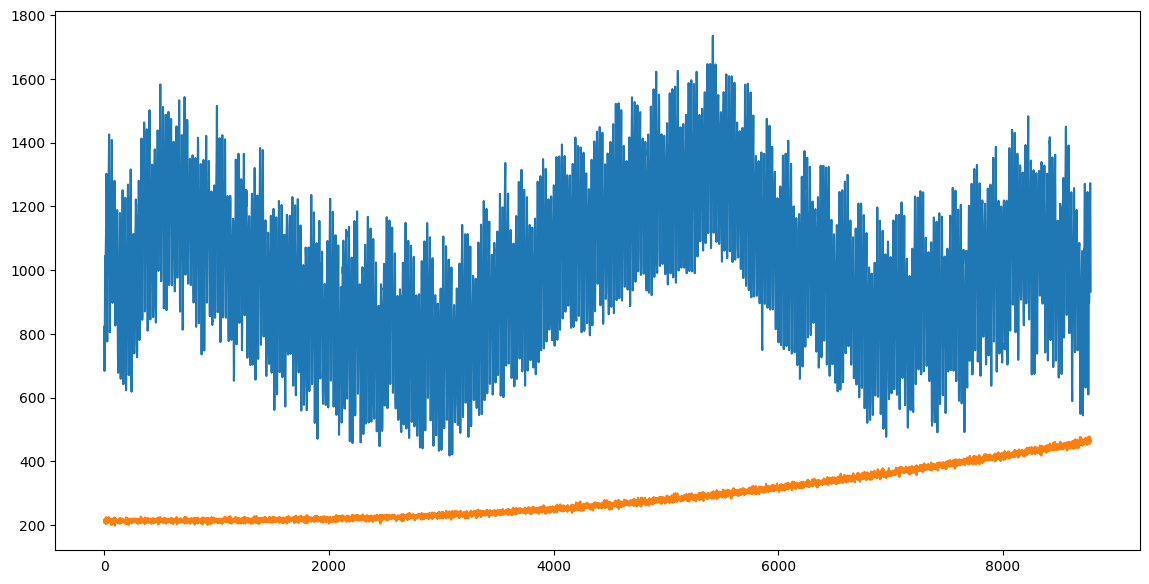

In [147]:
future_samps = samps['yhat'][list(future_df.index[future_df.ds >= '2008-01-01']), :]

plt.plot(future_samps.mean(axis=1))
plt.plot(future_samps.std(axis=1))

In [148]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('./models/mod1.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model



In [55]:
import plotly.graph_objects as go


def slider_plot(data, x, y):
    ''' Create a plotly lineplot with range slider '''
    # Create figure
    fig = go.Figure()
    # Show line
    fig.add_trace(go.Scatter(x=list(data[x]), y=list(data[y])))
    # Add range slider
    fig.update_layout(xaxis=dict(rangeslider=dict(visible=True), type="date"))
    
    fig.show()

    

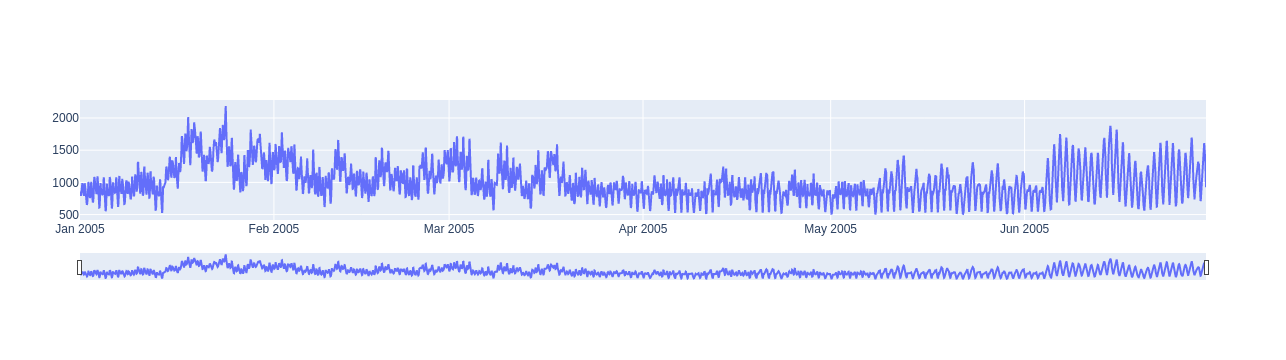

In [56]:
slider_plot(data=mod_data[mod_data.ds <= '2005-06-30'], x='ds', y='y')

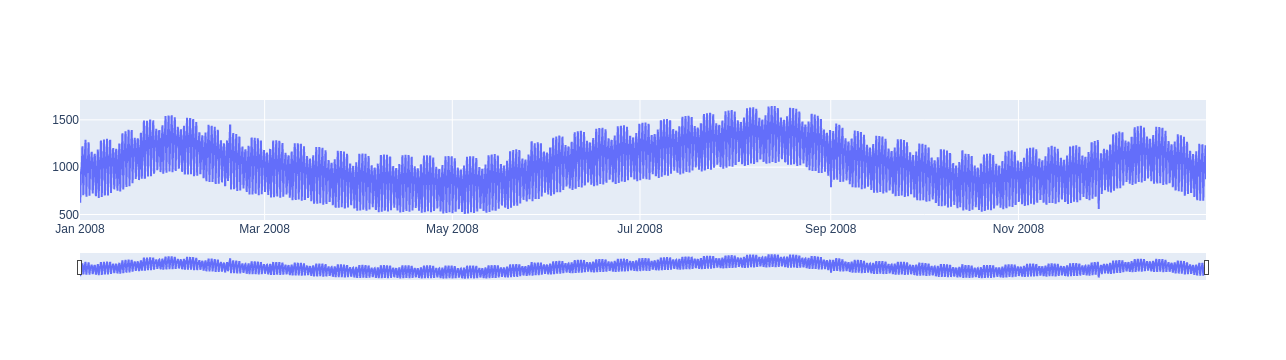

In [97]:
slider_plot(data=preds[preds.ds >= '2008-01-01'], x='ds', y='yhat')